In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
import bioframe
import random
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore, spearmanr, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

## DEGs

In [14]:
# Read GTF with gene annotation
genes = read_gtf('/DATA/users/magnitov/genomes/gencode.vM25.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,seqname,start,end,strand,gene_id,gene_type,gene_name
0,chr1,3073253,3074322,+,ENSMUSG00000102693.1,TEC,4933401J01Rik
3,chr1,3102016,3102125,+,ENSMUSG00000064842.1,snRNA,Gm26206
6,chr1,3205901,3671498,-,ENSMUSG00000051951.5,protein_coding,Xkr4
24,chr1,3252757,3253236,+,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
27,chr1,3365731,3368549,-,ENSMUSG00000103377.1,TEC,Gm37180


### IAA 6H vs DMSO

In [15]:
degs_6H = pd.read_csv('./degs/degs_6H_WAPL_CTCF_DESeq.csv', sep = '\s+', header = 0)
degs_6H['gene_id'] = degs_6H.index
degs_6H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,55.112201,0.006628,0.786117,0.008431,0.993273,1.0,ENSMUSG00000025902.13
ENSMUSG00000103922.1,55.896218,0.151218,0.404362,0.373966,0.708430,1.0,ENSMUSG00000103922.1
ENSMUSG00000033845.13,1571.177793,-0.064972,0.361728,-0.179614,0.857456,1.0,ENSMUSG00000033845.13
ENSMUSG00000025903.14,888.514519,-0.238749,0.287074,-0.831663,0.405599,1.0,ENSMUSG00000025903.14
ENSMUSG00000033813.15,518.938221,-0.181267,0.402465,-0.450393,0.652427,1.0,ENSMUSG00000033813.15


In [16]:
degs_6H = degs_6H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_6H = degs_6H[columns_to_save]

degs_6H.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
1279,chr2,101678429,101701669,Traf6,ENSMUSG00000027164.8,+,protein_coding,-3.282227,74.709691,8.580028e-14,2.428834e-10
9955,chr12,87795512,87795946,Gm21936,ENSMUSG00000113201.1,+,protein_coding,-3.202508,19.973890,3.981468e-02,1.000000e+00
12930,chr18,34542313,34548273,Wnt8a,ENSMUSG00000012282.2,+,protein_coding,-3.025027,86.214753,5.522482e-02,1.000000e+00
7069,chr9,30942562,30963838,Adamts8,ENSMUSG00000031994.13,+,protein_coding,-2.737883,38.005652,5.734997e-11,7.432133e-08
2635,chr4,34949074,35157484,Mob3b,ENSMUSG00000073910.10,-,protein_coding,-2.640832,23.606432,1.247307e-06,5.516995e-04


In [18]:
degs_6H_up = degs_6H[(degs_6H['padj'] < 0.01) & (degs_6H['log2FoldChange'] > 0)]
degs_6H_down = degs_6H[(degs_6H['padj'] < 0.01) & (degs_6H['log2FoldChange'] < 0)]
degs_6H_stable = degs_6H[~degs_6H['gene_id'].isin([x for x in degs_6H['gene_id'].values \
                                                   if x in degs_6H_down['gene_id'].values or x in degs_6H_up['gene_id'].values])]

print('Up-regulated:', len(degs_6H_up))
print('Down-regulated:', len(degs_6H_down))
print('No change:', len(degs_6H_stable))
print('Low expression:', len(genes) - len(degs_6H))

Up-regulated: 16
Down-regulated: 41
No change: 14097
Low expression: 41247


In [19]:
degs_6H_down['direction'] = ['down']*len(degs_6H_down)
degs_6H_up['direction'] = ['up']*len(degs_6H_up)
degs_6H_stable['direction'] = ['stable']*len(degs_6H_stable)

### IAA 24H vs DMSO

In [20]:
degs_24H = pd.read_csv('./degs/degs_24H_WAPL_CTCF_DESeq.csv', sep = '\s+', header = 0)
degs_24H['gene_id'] = degs_24H.index
degs_24H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,55.112201,1.767476,0.664715,2.658998,0.007837,0.101938,ENSMUSG00000025902.13
ENSMUSG00000103922.1,55.896218,0.039658,0.407835,0.097240,0.922535,0.999721,ENSMUSG00000103922.1
ENSMUSG00000033845.13,1571.177793,-0.026954,0.361782,-0.074505,0.940609,0.999721,ENSMUSG00000033845.13
ENSMUSG00000025903.14,888.514519,-0.106154,0.287079,-0.369773,0.711552,0.999721,ENSMUSG00000025903.14
ENSMUSG00000033813.15,518.938221,-0.549628,0.403270,-1.362929,0.172905,0.670804,ENSMUSG00000033813.15


In [21]:
degs_24H = degs_24H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_24H = degs_24H[columns_to_save]

degs_24H.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
7069,chr9,30942562,30963838,Adamts8,ENSMUSG00000031994.13,+,protein_coding,-4.306362,38.005652,2.130479e-15,1.525535e-12
314,chr1,84369839,84696221,Dner,ENSMUSG00000036766.12,-,protein_coding,-3.504999,99.390472,5.326453e-18,6.587854e-15
2464,chr3,135281221,135304426,Bdh2,ENSMUSG00000028167.15,+,protein_coding,-3.445602,51.411578,1.186300e-09,2.521815e-07
11870,chr16,30269302,30283256,Lrrc15,ENSMUSG00000052316.9,-,protein_coding,-3.365414,21.007670,5.475417e-04,1.427070e-02
2855,chr4,99656299,99658622,Foxd3,ENSMUSG00000067261.4,+,protein_coding,-3.317718,40.259811,5.502034e-11,1.559483e-08


In [22]:
degs_24H_up = degs_24H[(degs_24H['padj'] < 0.01) & (degs_24H['log2FoldChange'] > 0)]
degs_24H_down = degs_24H[(degs_24H['padj'] < 0.01) & (degs_24H['log2FoldChange'] < 0)]
degs_24H_stable = degs_24H[~degs_24H['gene_id'].isin([x for x in degs_24H['gene_id'].values \
                                                      if x in degs_24H_down['gene_id'].values or x in degs_24H_up['gene_id'].values])]

print('Up-regulated:', len(degs_24H_up))
print('Down-regulated:', len(degs_24H_down))
print('No change:', len(degs_24H_stable))
print('Low expression:', len(genes) - len(degs_24H))

Up-regulated: 234
Down-regulated: 212
No change: 13708
Low expression: 41247


In [23]:
degs_24H_down['direction'] = ['down']*len(degs_24H_down)
degs_24H_up['direction'] = ['up']*len(degs_24H_up)
degs_24H_stable['direction'] = ['stable']*len(degs_24H_stable)

### IAA 48H vs DMSO

In [24]:
degs_48H = pd.read_csv('./degs/degs_48H_WAPL_CTCF_DESeq.csv', sep = '\s+', header = 0)
degs_48H['gene_id'] = degs_48H.index
degs_48H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,55.112201,3.039199,0.624779,4.864436,0.000001,0.000018,ENSMUSG00000025902.13
ENSMUSG00000103922.1,55.896218,-0.153331,0.409372,-0.374553,0.707993,0.839064,ENSMUSG00000103922.1
ENSMUSG00000033845.13,1571.177793,-0.412531,0.361966,-1.139696,0.254413,0.458391,ENSMUSG00000033845.13
ENSMUSG00000025903.14,888.514519,-0.306460,0.287229,-1.066953,0.285993,0.489948,ENSMUSG00000025903.14
ENSMUSG00000033813.15,518.938221,-0.902709,0.403813,-2.235465,0.025387,0.089540,ENSMUSG00000033813.15


In [25]:
degs_48H = degs_48H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_48H = degs_48H[columns_to_save]

degs_48H.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
6837,chr8,118283733,119324921,Cdh13,ENSMUSG00000031841.19,+,protein_coding,-4.850100,7.925976,1.858270e-03,1.095458e-02
6080,chr7,132594878,132599637,Nkx1-2,ENSMUSG00000048528.7,-,protein_coding,-4.728420,97.292947,9.770177e-15,7.598191e-13
6551,chr8,78433010,78436645,Pou4f2,ENSMUSG00000031688.4,-,protein_coding,-4.553153,24.135815,3.224354e-08,7.493844e-07
417,chr1,119415465,119422248,Inhbb,ENSMUSG00000037035.5,-,protein_coding,-4.355177,21.956653,3.966481e-07,7.035285e-06
7069,chr9,30942562,30963838,Adamts8,ENSMUSG00000031994.13,+,protein_coding,-4.200399,38.005652,6.927756e-16,6.716127e-14


In [26]:
degs_48H_up = degs_48H[(degs_48H['padj'] < 0.01) & (degs_48H['log2FoldChange'] > 0)]
degs_48H_down = degs_48H[(degs_48H['padj'] < 0.01) & (degs_48H['log2FoldChange'] < 0)]
degs_48H_stable = degs_48H[~degs_48H['gene_id'].isin([x for x in degs_48H['gene_id'].values \
                                                      if x in degs_48H_down['gene_id'].values or x in degs_48H_up['gene_id'].values])]

print('Up-regulated:', len(degs_48H_up))
print('Down-regulated:', len(degs_48H_down))
print('No change:', len(degs_48H_stable))
print('Low expression:', len(genes) - len(degs_48H))

Up-regulated: 1396
Down-regulated: 964
No change: 11794
Low expression: 41247


In [27]:
degs_48H_down['direction'] = ['down']*len(degs_48H_down)
degs_48H_up['direction'] = ['up']*len(degs_48H_up)
degs_48H_stable['direction'] = ['stable']*len(degs_48H_stable)

### IAA 96H vs DMSO

In [28]:
degs_96H = pd.read_csv('./degs/degs_96H_WAPL_CTCF_DESeq.csv', sep = '\s+', header = 0)
degs_96H['gene_id'] = degs_96H.index
degs_96H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,55.112201,5.838779,0.601741,9.703148,2.923363e-22,9.468486e-21,ENSMUSG00000025902.13
ENSMUSG00000103922.1,55.896218,-0.832971,0.420017,-1.983185,4.734676e-02,7.946710e-02,ENSMUSG00000103922.1
ENSMUSG00000033845.13,1571.177793,-1.535794,0.362936,-4.231584,2.320510e-05,8.831939e-05,ENSMUSG00000033845.13
ENSMUSG00000025903.14,888.514519,-1.226730,0.288695,-4.249229,2.145080e-05,8.225810e-05,ENSMUSG00000025903.14
ENSMUSG00000033813.15,518.938221,-1.426123,0.404805,-3.522984,4.267172e-04,1.232766e-03,ENSMUSG00000033813.15


In [29]:
degs_96H = degs_96H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_96H = degs_96H[columns_to_save]

degs_96H.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
7406,chr9,76319577,76320846,Gm27234,ENSMUSG00000098894.1,+,antisense,-8.232981,63.906595,4.430184e-08,2.721563e-07
6224,chr8,11654924,11701063,1700016D06Rik,ENSMUSG00000031509.10,-,protein_coding,-8.147707,24.092867,2.923232e-07,1.574408e-06
3708,chr5,59953511,59956140,Gm43041,ENSMUSG00000104563.1,-,TEC,-7.877349,30.851020,1.983081e-07,1.099433e-06
336,chr1,87190607,87200070,Chrnd,ENSMUSG00000026251.13,+,protein_coding,-7.703490,14.260765,4.267759e-07,2.233945e-06
2443,chr3,129753758,129763884,6330410L21Rik,ENSMUSG00000105960.1,+,antisense,-7.662889,15.292288,1.471198e-06,7.065943e-06


In [30]:
degs_96H_up = degs_96H[(degs_96H['padj'] < 0.01) & (degs_96H['log2FoldChange'] > 0)]
degs_96H_down = degs_96H[(degs_96H['padj'] < 0.01) & (degs_96H['log2FoldChange'] < 0)]
degs_96H_stable = degs_96H[~degs_96H['gene_id'].isin([x for x in degs_96H['gene_id'].values \
                                                      if x in degs_96H_down['gene_id'].values or x in degs_96H_up['gene_id'].values])]

print('Up-regulated:', len(degs_96H_up))
print('Down-regulated:', len(degs_96H_down))
print('No change:', len(degs_96H_stable))
print('Low expression:', len(genes) - len(degs_96H))

Up-regulated: 3134
Down-regulated: 3148
No change: 7872
Low expression: 41247


In [31]:
degs_96H_down['direction'] = ['down']*len(degs_96H_down)
degs_96H_up['direction'] = ['up']*len(degs_96H_up)
degs_96H_stable['direction'] = ['stable']*len(degs_96H_stable)

## Volcano plots

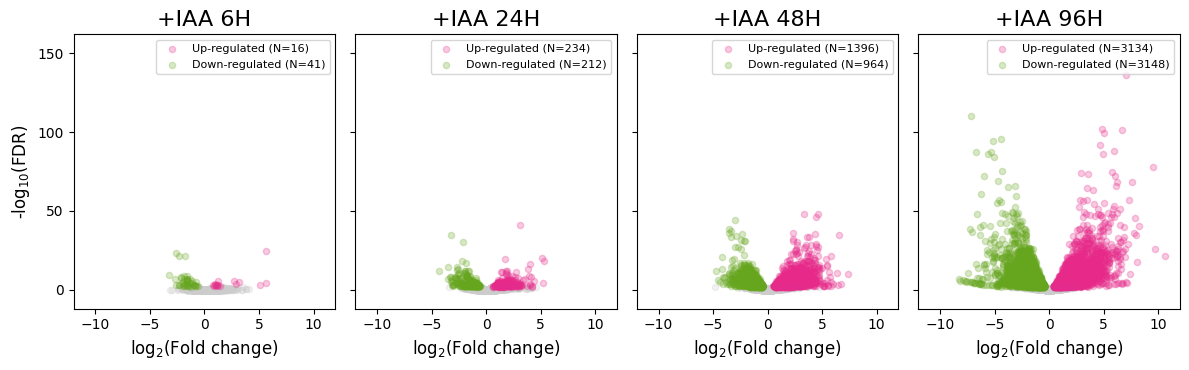

In [32]:
plt.figure(figsize = (12, 3.8))

plt.subplot(141)
plt.title('+IAA 6H', fontsize = 16)
plt.scatter(degs_6H_stable['log2FoldChange'], -np.log10(degs_6H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_6H_up['log2FoldChange'], -np.log10(degs_6H_up['padj']), 
            color = '#E72A8A', label = f'Up-regulated (N={len(degs_6H_up)})', alpha = 0.25, s = 20)
plt.scatter(degs_6H_down['log2FoldChange'], -np.log10(degs_6H_down['padj']), 
            color = '#66A61E', label = f'Down-regulated (N={len(degs_6H_down)})', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.ylabel('-log$_{10}$(FDR)', fontsize = 12)
plt.xlim((-12, 12))
plt.ylim((-12, 162))
plt.yticks([0, 50, 100, 150], [0, 50, 100, 150])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(142)
plt.title('+IAA 24H', fontsize = 16)
plt.scatter(degs_24H_stable['log2FoldChange'], -np.log10(degs_24H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_24H_up['log2FoldChange'], -np.log10(degs_24H_up['padj']), 
            color = '#E72A8A', label = f'Up-regulated (N={len(degs_24H_up)})', alpha = 0.25, s = 20)
plt.scatter(degs_24H_down['log2FoldChange'], -np.log10(degs_24H_down['padj']), 
            color = '#66A61E', label = f'Down-regulated (N={len(degs_24H_down)})', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-12, 12))
plt.ylim((-12, 162))
plt.yticks([0, 50, 100, 150], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(143)
plt.title('+IAA 48H', fontsize = 16)
plt.scatter(degs_48H_stable['log2FoldChange'], -np.log10(degs_48H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_48H_up['log2FoldChange'], -np.log10(degs_48H_up['padj']), 
            color = '#E72A8A', label = f'Up-regulated (N={len(degs_48H_up)})', alpha = 0.25, s = 20)
plt.scatter(degs_48H_down['log2FoldChange'], -np.log10(degs_48H_down['padj']), 
            color = '#66A61E', label = f'Down-regulated (N={len(degs_48H_down)})', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-12, 12))
plt.ylim((-12, 162))
plt.yticks([0, 50, 100, 150], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(144)
plt.title('+IAA 96H', fontsize = 16)
plt.scatter(degs_96H_stable['log2FoldChange'], -np.log10(degs_96H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_96H_up['log2FoldChange'], -np.log10(degs_96H_up['padj']), 
            color = '#E72A8A', label = f'Up-regulated (N={len(degs_96H_up)})', alpha = 0.25, s = 20)
plt.scatter(degs_96H_down['log2FoldChange'], -np.log10(degs_96H_down['padj']), 
            color = '#66A61E', label = f'Down-regulated (N={len(degs_96H_down)})', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-12, 12))
plt.ylim((-12, 162))
plt.yticks([0, 50, 100, 150], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

## DEGs overlap with fountains

In [33]:
genes = read_gtf('/DATA/users/magnitov/genomes/gencode.vM25.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.columns = ['chrom', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']
not_expressed_genes = genes[~genes['gene_id'].isin(degs_6H['gene_id'].values)]['gene_id'].values

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


In [34]:
distance_from_plume_base = 100000

In [35]:
plumes_fontanka = pd.read_csv('fountains_fontanka_merged.bed', sep = '\t', header = None)
plumes_fontanka.columns = ['chrom', 'start', 'end']
plumes_fontanka['start'] = plumes_fontanka['start'] - distance_from_plume_base
plumes_fontanka['end'] = plumes_fontanka['end'] + distance_from_plume_base
plumes_fontanka.head()

,chrom,start,end
0,chr1,6960000,7180000
1,chr1,11280000,11500000
2,chr1,15640000,15860000
3,chr1,20840000,21060000
4,chr1,23860000,24080000


In [36]:
genes_overlapping_plumes = bioframe.overlap(genes, plumes_fontanka, suffixes=('','_tacl_domain'))
genes_overlapping_plumes = genes_overlapping_plumes[~genes_overlapping_plumes['gene_id'].isin(not_expressed_genes)]

genes_inside_plumes = genes_overlapping_plumes.dropna()['gene_id'].values
genes_inside_plumes = np.unique(genes_inside_plumes)
genes_outside_plumes = genes_overlapping_plumes[genes_overlapping_plumes.isnull().any(axis=1)]['gene_id'].values
genes_outside_plumes = np.unique(genes_outside_plumes)

len(genes_outside_plumes), len(genes_inside_plumes)

(12377, 1777)

In [37]:
degs_6H = pd.concat([degs_6H_down, degs_6H_up, degs_6H_stable])
degs_24H = pd.concat([degs_24H_down, degs_24H_up, degs_24H_stable])
degs_48H = pd.concat([degs_48H_down, degs_48H_up, degs_48H_stable])
degs_96H = pd.concat([degs_96H_down, degs_96H_up, degs_96H_stable])

In [43]:
shuffled_fractions_6H, shuffled_fractions_24H, shuffled_fractions_48H, shuffled_fractions_96H = [], [], [], []

for i in range(100):
    degs_6H['direction_shuffled'] = random.sample(list(degs_6H['direction'].values), len(degs_6H))
    plume_degs_6H = pd.DataFrame([[len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                                  [len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                                  columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()
    fractions_degs_6H = [plume_degs_6H['Plume'].values[0]/(plume_degs_6H['Plume'].values[0] + plume_degs_6H['Other'].values[0]),
                         plume_degs_6H['Plume'].values[1]/(plume_degs_6H['Plume'].values[1] + plume_degs_6H['Other'].values[1]),
                         plume_degs_6H['Plume'].values[2]/(plume_degs_6H['Plume'].values[2] + plume_degs_6H['Other'].values[2])]
    shuffled_fractions_6H.append(fractions_degs_6H)

    degs_24H['direction_shuffled'] = random.sample(list(degs_24H['direction'].values), len(degs_24H))
    plume_degs_24H = pd.DataFrame([[len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                                   [len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                                   columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()
    fractions_degs_24H = [plume_degs_24H['Plume'].values[0]/(plume_degs_24H['Plume'].values[0] + plume_degs_24H['Other'].values[0]),
                          plume_degs_24H['Plume'].values[1]/(plume_degs_24H['Plume'].values[1] + plume_degs_24H['Other'].values[1]),
                          plume_degs_24H['Plume'].values[2]/(plume_degs_24H['Plume'].values[2] + plume_degs_24H['Other'].values[2])]
    shuffled_fractions_24H.append(fractions_degs_24H)
    
    degs_48H['direction_shuffled'] = random.sample(list(degs_48H['direction'].values), len(degs_48H))
    plume_degs_48H = pd.DataFrame([[len([x for x in degs_48H[degs_48H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_48H[degs_48H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_48H[degs_48H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                                   [len([x for x in degs_48H[degs_48H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_48H[degs_48H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_48H[degs_48H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                                   columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()
    fractions_degs_48H = [plume_degs_48H['Plume'].values[0]/(plume_degs_48H['Plume'].values[0] + plume_degs_48H['Other'].values[0]),
                          plume_degs_48H['Plume'].values[1]/(plume_degs_48H['Plume'].values[1] + plume_degs_48H['Other'].values[1]),
                          plume_degs_48H['Plume'].values[2]/(plume_degs_48H['Plume'].values[2] + plume_degs_48H['Other'].values[2])]
    shuffled_fractions_48H.append(fractions_degs_48H)
    
    degs_96H['direction_shuffled'] = random.sample(list(degs_96H['direction'].values), len(degs_96H))
    plume_degs_96H = pd.DataFrame([[len([x for x in degs_96H[degs_96H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_96H[degs_96H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_96H[degs_96H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                                   [len([x for x in degs_96H[degs_96H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_96H[degs_96H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_96H[degs_96H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                                   columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()
    fractions_degs_96H = [plume_degs_96H['Plume'].values[0]/(plume_degs_96H['Plume'].values[0] + plume_degs_96H['Other'].values[0]),
                          plume_degs_96H['Plume'].values[1]/(plume_degs_96H['Plume'].values[1] + plume_degs_96H['Other'].values[1]),
                          plume_degs_96H['Plume'].values[2]/(plume_degs_96H['Plume'].values[2] + plume_degs_96H['Other'].values[2])]
    shuffled_fractions_96H.append(fractions_degs_96H)

In [44]:
mean_shuffled_fractions_6H = np.mean(shuffled_fractions_6H, axis = 0)
min_shuffled_fractions_6H = np.min(shuffled_fractions_6H, axis = 0)
max_shuffled_fractions_6H = np.max(shuffled_fractions_6H, axis = 0)

mean_shuffled_fractions_24H = np.mean(shuffled_fractions_24H, axis = 0)
min_shuffled_fractions_24H = np.min(shuffled_fractions_24H, axis = 0)
max_shuffled_fractions_24H = np.max(shuffled_fractions_24H, axis = 0)

mean_shuffled_fractions_48H = np.mean(shuffled_fractions_48H, axis = 0)
min_shuffled_fractions_48H = np.min(shuffled_fractions_48H, axis = 0)
max_shuffled_fractions_48H = np.max(shuffled_fractions_48H, axis = 0)

mean_shuffled_fractions_96H = np.mean(shuffled_fractions_96H, axis = 0)
min_shuffled_fractions_96H = np.min(shuffled_fractions_96H, axis = 0)
max_shuffled_fractions_96H = np.max(shuffled_fractions_96H, axis = 0)

print(mean_shuffled_fractions_6H, min_shuffled_fractions_6H, max_shuffled_fractions_6H)
print(mean_shuffled_fractions_24H, min_shuffled_fractions_24H, max_shuffled_fractions_24H)
print(mean_shuffled_fractions_48H, min_shuffled_fractions_48H, max_shuffled_fractions_48H)
print(mean_shuffled_fractions_96H, min_shuffled_fractions_96H, max_shuffled_fractions_96H)

[0.12609756 0.11375    0.12555934] [0.        0.        0.1249202] [0.29268293 0.3125     0.12591331]
[0.12580189 0.12529915 0.12554786] [0.0754717  0.08547009 0.12416107] [0.18396226 0.16239316 0.12656843]
[0.12640041 0.12356017 0.12571307] [0.09751037 0.10601719 0.1219264 ] [0.1473029  0.1525788  0.12938782]
[0.12542884 0.12588705 0.12545986] [0.10991105 0.11263561 0.11775915] [0.14008895 0.1397575  0.13173272]


In [41]:
plume_degs_6H = pd.DataFrame([[len(degs_6H_down[degs_6H_down['gene_id'].isin(genes_inside_plumes)]),
                               len(degs_6H_up[degs_6H_up['gene_id'].isin(genes_inside_plumes)]),
                               len(degs_6H_stable[degs_6H_stable['gene_id'].isin(genes_inside_plumes)])],
                              [len(degs_6H_down[degs_6H_down['gene_id'].isin(genes_outside_plumes)]),
                               len(degs_6H_up[degs_6H_up['gene_id'].isin(genes_outside_plumes)]),
                               len(degs_6H_stable[degs_6H_stable['gene_id'].isin(genes_outside_plumes)])]],
                              columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()

plume_degs_24H = pd.DataFrame([[len(degs_24H_down[degs_24H_down['gene_id'].isin(genes_inside_plumes)]),
                                len(degs_24H_up[degs_24H_up['gene_id'].isin(genes_inside_plumes)]),
                                len(degs_24H_stable[degs_24H_stable['gene_id'].isin(genes_inside_plumes)])],
                               [len(degs_24H_down[degs_24H_down['gene_id'].isin(genes_outside_plumes)]),
                                len(degs_24H_up[degs_24H_up['gene_id'].isin(genes_outside_plumes)]),
                                len(degs_24H_stable[degs_24H_stable['gene_id'].isin(genes_outside_plumes)])]],
                              columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()

plume_degs_48H = pd.DataFrame([[len(degs_48H_down[degs_48H_down['gene_id'].isin(genes_inside_plumes)]),
                                len(degs_48H_up[degs_48H_up['gene_id'].isin(genes_inside_plumes)]),
                                len(degs_48H_stable[degs_48H_stable['gene_id'].isin(genes_inside_plumes)])],
                               [len(degs_48H_down[degs_48H_down['gene_id'].isin(genes_outside_plumes)]),
                                len(degs_48H_up[degs_48H_up['gene_id'].isin(genes_outside_plumes)]),
                                len(degs_48H_stable[degs_48H_stable['gene_id'].isin(genes_outside_plumes)])]],
                              columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()

plume_degs_96H = pd.DataFrame([[len(degs_96H_down[degs_96H_down['gene_id'].isin(genes_inside_plumes)]),
                                len(degs_96H_up[degs_96H_up['gene_id'].isin(genes_inside_plumes)]),
                                len(degs_96H_stable[degs_96H_stable['gene_id'].isin(genes_inside_plumes)])],
                               [len(degs_96H_down[degs_96H_down['gene_id'].isin(genes_outside_plumes)]),
                                len(degs_96H_up[degs_96H_up['gene_id'].isin(genes_outside_plumes)]),
                                len(degs_96H_stable[degs_96H_stable['gene_id'].isin(genes_outside_plumes)])]],
                              columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()

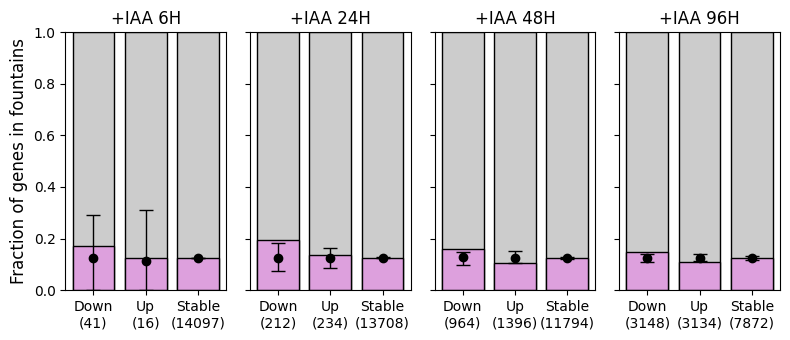

In [44]:
plt.figure(figsize = (8, 3.5))

plt.subplot(141)
plt.title('+IAA 6H')
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [plume_degs_6H['Plume'].values[0]/(plume_degs_6H['Plume'].values[0] + plume_degs_6H['Other'].values[0]),
                    plume_degs_6H['Plume'].values[1]/(plume_degs_6H['Plume'].values[1] + plume_degs_6H['Other'].values[1]),
                    plume_degs_6H['Plume'].values[2]/(plume_degs_6H['Plume'].values[2] + plume_degs_6H['Other'].values[2])],
        edgecolor = 'k', lw = 1, color = 'plum')
plt.errorbar([0, 1, 2], mean_shuffled_fractions_6H, yerr = (mean_shuffled_fractions_6H-min_shuffled_fractions_6H, 
                                                            max_shuffled_fractions_6H-mean_shuffled_fractions_6H), 
             capsize = 5, zorder = 3, fmt = 'o',  color = 'k', lw = 1)
plt.xticks([0, 1, 2], ['Down\n(' + str(np.sum(plume_degs_6H.values[0])) + ')', 
                       'Up\n(' + str(np.sum(plume_degs_6H.values[1])) + ')', 
                       'Stable\n(' + str(np.sum(plume_degs_6H.values[2])) + ')'])
plt.ylabel('Fraction of genes in fountains', fontsize = 12)
plt.ylim((0, 1))

plt.subplot(142)
plt.title('+IAA 24H')
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [plume_degs_24H['Plume'].values[0]/(plume_degs_24H['Plume'].values[0] + plume_degs_24H['Other'].values[0]),
                    plume_degs_24H['Plume'].values[1]/(plume_degs_24H['Plume'].values[1] + plume_degs_24H['Other'].values[1]),
                    plume_degs_24H['Plume'].values[2]/(plume_degs_24H['Plume'].values[2] + plume_degs_24H['Other'].values[2])],
        edgecolor = 'k', lw = 1, color = 'plum')
plt.errorbar([0, 1, 2], mean_shuffled_fractions_24H, yerr = (mean_shuffled_fractions_24H-min_shuffled_fractions_24H, 
                                                             max_shuffled_fractions_24H-mean_shuffled_fractions_24H), 
             capsize = 5, zorder = 3, fmt = 'o',  color = 'k', lw = 1)
plt.xticks([0, 1, 2], ['Down\n(' + str(np.sum(plume_degs_24H.values[0])) + ')', 
                       'Up\n(' + str(np.sum(plume_degs_24H.values[1])) + ')', 
                       'Stable\n(' + str(np.sum(plume_degs_24H.values[2])) + ')'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
plt.ylim((0, 1))

plt.subplot(143)
plt.title('+IAA 48H')
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [plume_degs_48H['Plume'].values[0]/(plume_degs_48H['Plume'].values[0] + plume_degs_48H['Other'].values[0]),
                    plume_degs_48H['Plume'].values[1]/(plume_degs_48H['Plume'].values[1] + plume_degs_48H['Other'].values[1]),
                    plume_degs_48H['Plume'].values[2]/(plume_degs_48H['Plume'].values[2] + plume_degs_48H['Other'].values[2])],
        edgecolor = 'k', lw = 1, color = 'plum')
plt.errorbar([0, 1, 2], mean_shuffled_fractions_48H, yerr = (mean_shuffled_fractions_48H-min_shuffled_fractions_48H, 
                                                             max_shuffled_fractions_48H-mean_shuffled_fractions_48H), 
             capsize = 5, zorder = 3, fmt = 'o',  color = 'k', lw = 1)
plt.xticks([0, 1, 2], ['Down\n(' + str(np.sum(plume_degs_48H.values[0])) + ')', 
                       'Up\n(' + str(np.sum(plume_degs_48H.values[1])) + ')', 
                       'Stable\n(' + str(np.sum(plume_degs_48H.values[2])) + ')'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
plt.ylim((0, 1))

plt.subplot(144)
plt.title('+IAA 96H')
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [plume_degs_96H['Plume'].values[0]/(plume_degs_96H['Plume'].values[0] + plume_degs_96H['Other'].values[0]),
                    plume_degs_96H['Plume'].values[1]/(plume_degs_96H['Plume'].values[1] + plume_degs_96H['Other'].values[1]),
                    plume_degs_96H['Plume'].values[2]/(plume_degs_96H['Plume'].values[2] + plume_degs_96H['Other'].values[2])],
        edgecolor = 'k', lw = 1, color = 'plum')
plt.errorbar([0, 1, 2], mean_shuffled_fractions_96H, yerr = (mean_shuffled_fractions_96H-min_shuffled_fractions_96H, 
                                                             max_shuffled_fractions_96H-mean_shuffled_fractions_96H), 
             capsize = 5, zorder = 3, fmt = 'o',  color = 'k', lw = 1)
plt.xticks([0, 1, 2], ['Down\n(' + str(np.sum(plume_degs_96H.values[0])) + ')', 
                       'Up\n(' + str(np.sum(plume_degs_96H.values[1])) + ')', 
                       'Stable\n(' + str(np.sum(plume_degs_96H.values[2])) + ')'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
plt.ylim((0, 1))

plt.tight_layout()
plt.show()